In [1]:
import tqdm
import torch
import numpy as np
import torchviz

from torch.utils.tensorboard import SummaryWriter
from torch.optim import SGD, Adam
from torch.nn import MSELoss
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch import nn

# Операции с тензорами

In [3]:
x = torch.tensor(2.0, dtype=torch.float32)
y = torch.tensor([1.0, 2.0, 3.0])
x + y

tensor([3., 4., 5.])

In [4]:
x = torch.empty(2, 2)
x

tensor([[-3.1126e-32,  4.5730e-41],
        [ 1.7224e-37,  0.0000e+00]])

In [5]:
torch.randn(2, 3)

tensor([[-0.4986, -2.2621, -0.8062],
        [-0.7100, -0.1929,  2.6461]])

In [6]:
torch.randn(2, 3).view((-1, 1))

tensor([[ 0.5380],
        [-1.1742],
        [ 0.4327],
        [ 0.7635],
        [-0.4271],
        [ 0.6769]])

# Автоматическое дифференцировние

tensor(-2.) tensor(2.)


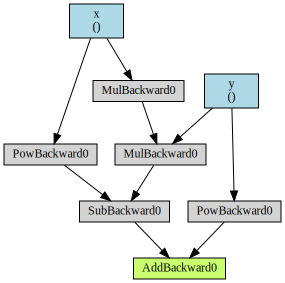

In [7]:
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)

val = x ** 2 - 2 * x * y + y ** 2
val.backward()

print(x.grad, y.grad)

torchviz.make_dot(val, {'x': x, 'y': y})

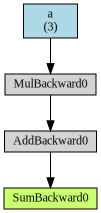

In [8]:
a = torch.tensor([1, 2, 3.], requires_grad=True) 
b = (5 * a + 2).sum()

torchviz.make_dot(b, {'a': a})

# Градиентный спуск

In [9]:
x = torch.tensor(2., requires_grad=True)
lr = 1e-2

for i in range(500):
    val = x ** 2 - 2 * x + 1
    val.backward()
    
    with torch.no_grad(): 
        x -= lr * x.grad
    
    x.grad.zero_()

print(x)

tensor(1.0000, requires_grad=True)


# Линейная регрессия

### Сгенерируем тренировочное, тестовое и валидационное множества

In [10]:
class DataGen:
    def __init__(self,  
            n=3, 
            a=[1.2, 3.0, -1.5],
            b=[25]):                
        
        self.n = 3        
        self.a = np.array(a).reshape((1, -1))
        self.b = np.array(b).reshape((1, -1))
        
    def gen_Xy(self, count=50):
        a, b = self.a, self.b
        
        noise = np.random.normal(0., 1., size=(count, 1))
        X = np.random.uniform(-30.0, 30.0, size=(count, self.n))
        y = X @ a.T + self.b + noise
        
        return X, y
        
    def gen_Xy_torch(self, count=50, device='cpu'):
        X, y = self.gen_Xy(count)
        return [torch.tensor(t, dtype=torch.float, device=device) for t in (X, y) ]
        

In [11]:
n, l, t, v = 3, 300, 50, 10
dg = DataGen(n=n)

X_train, y_train = dg.gen_Xy_torch(l)
X_test, y_test = dg.gen_Xy_torch(t)
X_val, y_val = dg.gen_Xy_torch(t)

# Простой градиентый спуск

In [12]:
a = torch.randn((1, n), requires_grad=True)
b = torch.randn((1, 1), requires_grad=True)

learnin_rate = 1e-3
max_epochs = 1000

for epoch in tqdm.trange(max_epochs):
    y_pred = torch.mm(X_train, a.T) + b
    mse = ((y_train - y_pred) ** 2).mean()
    
    mse.backward()
    with torch.no_grad():
        a -= learnin_rate * a.grad
        b -= learnin_rate * b.grad
        
    a.grad.zero_()
    b.grad.zero_()

print(a) 
print(b)    

100%|██████████| 1000/1000 [00:00<00:00, 1907.57it/s]

tensor([[ 1.1885,  2.9742, -1.4957]], requires_grad=True)
tensor([[21.6668]], requires_grad=True)


# Встроенные оптимизаторы (SGD) и функция потерь (MSELoss)

In [13]:
a = torch.randn((1, n), requires_grad=True)
b = torch.randn((1, 1), requires_grad=True)

optimizer = SGD([a, b], lr=1e-3)
loss = MSELoss()

max_epochs = 1000
for epoch in tqdm.trange(max_epochs):
    y_pred = torch.mm(X_train, a.T) + b
    mse = loss(y_train, y_pred)
    
    mse.backward()

    optimizer.step()
    optimizer.zero_grad()    

print(a) 
print(b)    

100%|██████████| 1000/1000 [00:00<00:00, 2154.51it/s]

tensor([[ 1.1883,  2.9736, -1.4957]], requires_grad=True)
tensor([[21.5760]], requires_grad=True)


# Батчи

In [14]:
a = torch.randn((1, n), requires_grad=True)
b = torch.randn((1, 1), requires_grad=True)

optimizer = SGD([a, b], lr=1e-3)
loss = MSELoss()

max_epochs = 1000
batch_size = 30
l = len(X_train)
for epoch in tqdm.trange(max_epochs):
    for batch in range((l + batch_size - 1) // batch_size): 
        s, e = (batch * batch_size), min((batch + 1) * batch_size, l)
        X_batch = X_train[s:e]
        
        y_pred = torch.mm(X_batch, a.T) + b
        mse = loss(y_train[s:e], y_pred)

        mse.backward()

        optimizer.step()
        optimizer.zero_grad()    

print(a) 
print(b)    

100%|██████████| 1000/1000 [00:03<00:00, 250.45it/s]

tensor([[ 1.2050,  2.9948, -1.4963]], requires_grad=True)
tensor([[25.0770]], requires_grad=True)


# Батчи через Dataset и Dataloader

In [15]:
a = torch.randn((1, n), requires_grad=True)
b = torch.randn((1, 1), requires_grad=True)

optimizer = SGD([a, b], lr=1e-3)
loss = MSELoss()
dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset=dataset, batch_size=30)

max_epochs = 1000
for epoch in tqdm.trange(max_epochs):
    for X_batch, y_batch in data_loader:                
        y_pred = torch.mm(X_batch, a.T) + b
        mse = loss(y_batch, y_pred)

        mse.backward()

        optimizer.step()
        optimizer.zero_grad()    

print(a) 
print(b) 

100%|██████████| 1000/1000 [00:06<00:00, 154.66it/s]

tensor([[ 1.2050,  2.9948, -1.4963]], requires_grad=True)
tensor([[25.0770]], requires_grad=True)


# Расширение nn.Module

In [16]:
class LinearRegression(nn.Module):
    def __init__(self, n=3):
        super().__init__()
        self.linear = nn.Linear(n, 1)
                
    def forward(self, x):        
        return self.linear(x)
    

model = LinearRegression(n)
#model = nn.Sequential(nn.Linear(n, 1))
optimizer = SGD(model.parameters(), lr=1e-3)

loss = MSELoss()
dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset=dataset, batch_size=30)

max_epochs = 1000
for epoch in tqdm.trange(max_epochs):
    for X_batch, y_batch in data_loader:   
        model.train()
        y_pred = model(X_batch)
        mse = loss(y_batch, y_pred)

        mse.backward()

        optimizer.step()
        optimizer.zero_grad()    

print(model.state_dict()['linear.weight'])      
print(model.state_dict()['linear.bias'])    

100%|██████████| 1000/1000 [00:07<00:00, 138.52it/s]

tensor([[ 1.2050,  2.9948, -1.4963]])
tensor([25.0770])


# Tensorboard

Запуск в командной строке:

```tensorboard --logdir .```

In [17]:
writer = SummaryWriter()

model = nn.Sequential(nn.Linear(n, 1))
optimizer = SGD(model.parameters(), lr=1e-3)

loss = MSELoss()
dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=dataset, batch_size=30)

max_epochs = 100
for epoch in tqdm.trange(max_epochs):
    for X_batch, y_batch in train_loader:   
        model.train()
        y_pred = model(X_batch)
        mse = loss(y_batch, y_pred)

        mse.backward()        

        optimizer.step()
        optimizer.zero_grad()  
        
    if epoch % 3 == 0:
        with torch.no_grad():
            model.eval()
            y_pred = model(X_val)
            mse_val = loss(y_val, y_pred)
            
            stat = { 'mse_validation': mse_val.item(),
                     'b': model.state_dict()['0.bias']    
            }
            writer.add_graph(model, X_val)
            writer.add_scalars('training/stat', stat, epoch)
            torch.save(model, 'checkpoint')
            
writer.close()

print(model.state_dict()['0.weight'])      
print(model.state_dict()['0.bias'])    

100%|██████████| 100/100 [00:01<00:00, 86.18it/s]


tensor([[ 1.2289,  2.9694, -1.5027]])
tensor([21.6039])


# Использование Ignite

In [18]:
import torch.nn.functional as F

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import MeanSquaredError

max_epochs = 100

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=30)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(dataset=val_dataset, batch_size=10)

model = nn.Sequential(nn.Linear(n, 1))
optimizer = SGD(model.parameters(), lr=1e-3)

loss = MeanSquaredError()

trainer = create_supervised_trainer(model, optimizer, F.mse_loss)
evaluator = create_supervised_evaluator(model,  metrics={'mse': loss})

writer = SummaryWriter()
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    mse = metrics['mse']
    writer.add_scalar('training/mse_train', mse, engine.state.epoch)

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    mse = metrics['mse']    
    print(f'Validation Results - Epoch: {engine.state.epoch},  MSE: {mse:.2f}')                  
    writer.add_scalar('training/mse_validation', mse, engine.state.epoch)
        
trainer.run(train_loader, max_epochs=max_epochs)

writer.close()

Validation Results - Epoch: 1,  MSE: 611.73
Validation Results - Epoch: 2,  MSE: 587.82
Validation Results - Epoch: 3,  MSE: 564.85
Validation Results - Epoch: 4,  MSE: 542.78
Validation Results - Epoch: 5,  MSE: 521.57
Validation Results - Epoch: 6,  MSE: 501.19
Validation Results - Epoch: 7,  MSE: 481.61
Validation Results - Epoch: 8,  MSE: 462.79
Validation Results - Epoch: 9,  MSE: 444.71
Validation Results - Epoch: 10,  MSE: 427.34
Validation Results - Epoch: 11,  MSE: 410.64
Validation Results - Epoch: 12,  MSE: 394.60
Validation Results - Epoch: 13,  MSE: 379.19
Validation Results - Epoch: 14,  MSE: 364.38
Validation Results - Epoch: 15,  MSE: 350.15
Validation Results - Epoch: 16,  MSE: 336.48
Validation Results - Epoch: 17,  MSE: 323.34
Validation Results - Epoch: 18,  MSE: 310.71
Validation Results - Epoch: 19,  MSE: 298.58
Validation Results - Epoch: 20,  MSE: 286.92
Validation Results - Epoch: 21,  MSE: 275.72
Validation Results - Epoch: 22,  MSE: 264.96
Validation Results 